# Python Machine Learning - Code Examples

Compressing Data via Dimensionality Reduction

### Overview

- [Unsupervised dimensionality reduction via principal component analysis 128](#Unsupervised-dimensionality-reduction-via-principal-component-analysis-128)
  - [The main steps behind principal component analysis](#The-main-steps-behind-principal-component-analysis)
  - [Extracting the principal components step-by-step](#Extracting-the-principal-components-step-by-step)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Principal component analysis versus linear discriminant analysis](#Principal-component-analysis-versus-linear-discriminant-analysis)
  - [The inner workings of linear discriminant analysis](#The-inner-workings-of-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting samples onto the new feature space](#Projecting-samples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
  - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
  - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
    - [Example 1 – separating half-moon shapes](#Example-1:-Separating-half-moon-shapes)
    - [Example 2 – separating concentric circles](#Example-2:-Separating-concentric-circles)
  - [Projecting new data points](#Projecting-new-data-points)
  - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
- [Summary](#Summary)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

# Unsupervised dimensionality reduction via principal component analysis

## Extracting the principal components step-by-step

In [3]:
import pandas as pd

#df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
#                      'machine-learning-databases/wine/wine.data',
#                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
print(df_wine['Class label'].unique())

[1 2 3]


<hr>

Splitting the data into 70% training and 30% test subsets.

In [6]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standardizing the data.

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Note**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 samples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify samples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these samples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify samples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- sample5: -18.37 -> class 2
- sample6: -17.15 -> class 2
- sample7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new samples" are much lower than every standardized feature in the training set.

---

Eigendecomposition of the covariance matrix.

In [9]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


**Note**: 

Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


<br>
<br>

## Total and explained variance

In [10]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

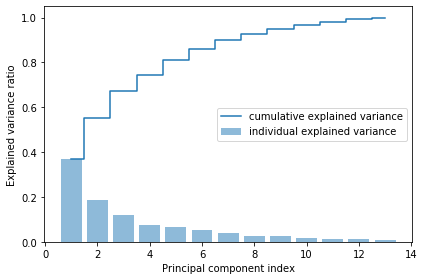

In [11]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

<br>
<br>

## Feature transformation

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [13]:
print(eigen_pairs)

[(4.842745315655898, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651])), (2.4160245870352255, array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
        0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
       -0.20716433, -0.24902536,  0.38022942])), (1.5484582488203513, array([-0.13774873,  0.09615039,  0.67777567,  0.62504055,  0.19613548,
        0.14031057,  0.11705386,  0.13121778,  0.0304309 , -0.07992997,
        0.05305915,  0.13239103, -0.07065022])), (0.9612043774977367, array([-0.0032961 ,  0.56264669, -0.10897711,  0.0338187 , -0.36751107,
        0.24024513,  0.1870533 , -0.02292622,  0.49626233,  0.10648294,
       -0.36905375,  0.14201609, -0.16768217])), (0.8416616104578422, array([-0.29062523,  0.08953787, -0.16083499,  0.05158734,  0.67648707,
       -0.11851114, -0.10710035, -0.50758161,  0.20

In [14]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**Note**
Depending on which version of NumPy and LAPACK you are using, you may obtain the Matrix W with its signs flipped. Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue,


then $-v$ is also an eigenvector that has the same eigenvalue, since
$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

In [15]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

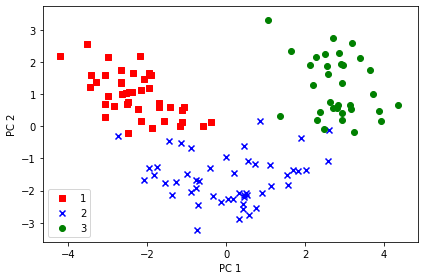

In [27]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

<br>
<br>

## Principal component analysis in scikit-learn

**NOTE**

The following four code cells has been added in addition to the content to the book, to illustrate how to replicate the results from our own PCA implementation in scikit-learn:

In [28]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

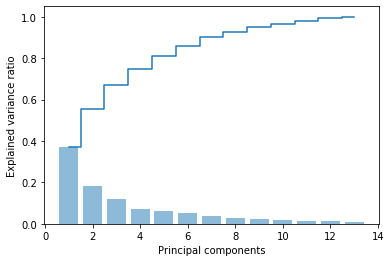

In [29]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [71]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
print(pca.explained_variance_ratio_)
X_test_pca = pca.transform(X_test_std)

[0.3695 0.1843]


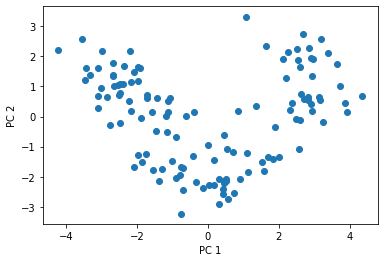

In [32]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [33]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

Training logistic regression classifier using the first 2 principal components.

In [34]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


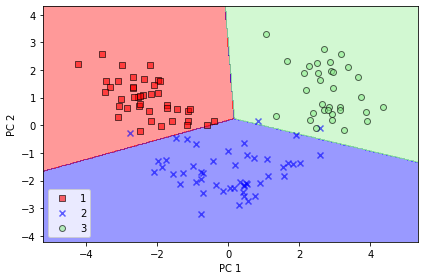

In [35]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


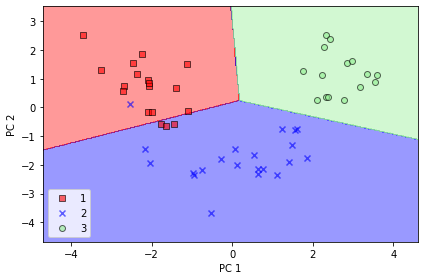

In [36]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

<br>
<br>

# Supervised data compression via linear discriminant analysis

## Principal component analysis versus linear discriminant analysis

<br>
<br>

## Computing the scatter matrices

Calculate the mean vectors for each class:

In [39]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Compute the within-class scatter matrix:

In [40]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [29]:
print(S_W)

[[ 5.0722e+01  3.1007e+00 -7.9323e+00 -5.7848e+00 -2.8879e+00  7.8990e+00
   2.4543e+00  9.3932e-01  9.0781e-01  1.5486e+01  7.0293e+00 -1.8659e+00
   4.9370e+00]
 [ 3.1007e+00  9.0179e+01  4.7074e+00  1.4750e+01 -1.0900e+01 -8.8059e-02
   9.7797e-01  8.4547e+00  4.4732e+00 -1.4494e+01 -2.0361e+01  3.5876e+00
  -1.1176e+01]
 [-7.9323e+00  4.7074e+00  1.1189e+02  7.0126e+01  2.2213e+01  1.5505e+01
   1.4856e+01  2.0454e+01 -2.3344e+00  1.3787e+00  5.6585e+00  8.1917e+00
   3.2570e-01]
 [-5.7848e+00  1.4750e+01  7.0126e+01  9.2147e+01  1.2485e+01  6.2091e+00
   6.2783e+00  1.2735e+01 -4.7597e+00 -4.1511e+00  1.1779e+00  1.1633e+01
  -4.5296e+00]
 [-2.8879e+00 -1.0900e+01  2.2213e+01  1.2485e+01  1.0605e+02  1.0950e+01
   5.2875e+00 -2.1136e+01  1.3076e+01  5.9930e+00  8.4568e+00 -5.3128e-01
   1.1845e+01]
 [ 7.8990e+00 -8.8059e-02  1.5505e+01  6.2091e+00  1.0950e+01  5.7194e+01
   2.8971e+01 -7.4850e+00  3.0810e+01  1.5516e+01  6.6816e-01  1.9382e+01
   6.3808e+00]
 [ 2.4543e+00  9.7797e

Better: covariance matrix since classes are not equally distributed:

In [41]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [46]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [45]:
print(S_W)

[[ 1.2448  0.0967 -0.1276 -0.1105 -0.0726  0.2374  0.0753  0.0231  0.1102
   0.4261  0.1411 -0.0155  0.1224]
 [ 0.0967  2.2666  0.1168  0.3517 -0.2622 -0.0467 -0.0186  0.2194  0.0187
  -0.3939 -0.4167  0.0787 -0.2492]
 [-0.1276  0.1168  2.6024  1.6442  0.5364  0.3947  0.3191  0.4553 -0.0353
   0.06    0.167   0.1987 -0.0081]
 [-0.1105  0.3517  1.6442  2.1604  0.325   0.1535  0.1222  0.273  -0.0824
  -0.068   0.0336  0.2548 -0.1201]
 [-0.0726 -0.2622  0.5364  0.325   2.4397  0.2384  0.1433 -0.5166  0.2566
   0.1445  0.1777 -0.0058  0.2509]
 [ 0.2374 -0.0467  0.3947  0.1535  0.2384  1.352   0.6416 -0.0781  0.7644
   0.4392  0.0177  0.4359  0.1554]
 [ 0.0753 -0.0186  0.3191  0.1222  0.1433  0.6416  0.6968 -0.2588  0.5765
   0.3851 -0.0408  0.2525  0.0748]
 [ 0.0231  0.2194  0.4553  0.273  -0.5166 -0.0781 -0.2588  2.1795 -0.2801
  -0.0363  0.1208 -0.332  -0.1485]
 [ 0.1102  0.0187 -0.0353 -0.0824  0.2566  0.7644  0.5765 -0.2801  2.1792
   0.6795 -0.1815  0.2323  0.1568]
 [ 0.4261 -0.3939  

Compute the between-class scatter matrix:

In [47]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [37]:
print(S_B)

[[ 73.2779   5.1521  29.3409 -37.8053  35.3288  27.8688  24.4037 -10.917
   11.9293  51.2816   0.2198  -0.3445  73.9711]
 [  5.1521  33.8209   5.5342  17.6688  -3.0595 -41.4067 -51.4514  32.9397
  -31.0444  36.0237 -47.4845 -53.4785 -18.4551]
 [ 29.3409   5.5342  12.1084 -13.0286  13.5707   6.6597   4.2554  -0.8742
    1.4687  23.8967  -4.84    -5.6837  27.1642]
 [-37.8053  17.6688 -13.0286  31.8532 -21.5944 -40.7237 -44.8903  26.1101
  -25.5242  -6.7623 -28.9705 -32.2968 -52.5343]
 [ 35.3288  -3.0595  13.5707 -21.5944  17.9512  20.621   20.5742 -10.8479
   11.0338  19.3529   7.9757   8.6902  39.5823]
 [ 27.8688 -41.4067   6.6597 -40.7237  20.621   66.8061  78.1916 -47.8401
   45.861  -22.5142  61.6487  69.1515  58.7931]
 [ 24.4037 -51.4514   4.2554 -44.8903  20.5742  78.1916  92.6119 -57.1978
   54.6364 -34.4354  75.5525  84.8261  62.2248]
 [-10.917   32.9397  -0.8742  26.1101 -10.8479 -47.8401 -57.1978  35.584
  -33.8973  25.0189 -47.8855 -53.8    -34.852 ]
 [ 11.9293 -31.0444   1.46

<br>
<br>

## Selecting linear discriminants for the new feature subspace

Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [48]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Note**:
    
Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


Sort eigenvectors in descending order of the eigenvalues:

In [49]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.7615221897938
3.389259780547781e-14
2.842170943040401e-14
1.9284611807586422e-14
1.9284611807586422e-14
1.8639179987230033e-14
1.8639179987230033e-14
7.057897559458914e-15
7.057897559458914e-15
6.596592553773414e-15
3.81059209269662e-15
3.3908455462202616e-15


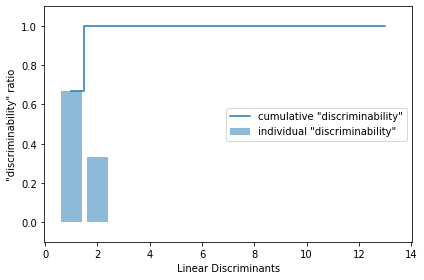

In [50]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_07.png', dpi=300)
plt.show()

In [51]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


<br>
<br>

## Projecting samples onto the new feature space

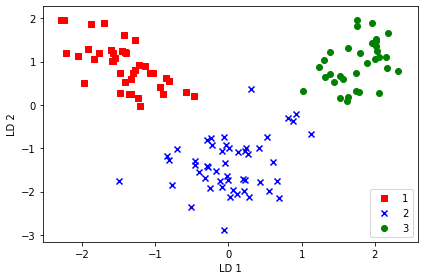

In [52]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/05_08.png', dpi=300)
plt.show()

<br>
<br>

## LDA via scikit-learn

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a s

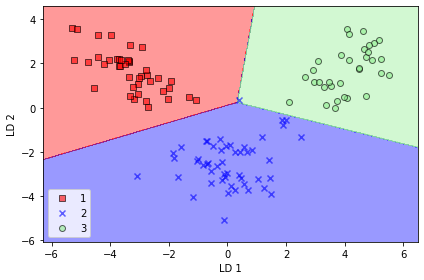

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


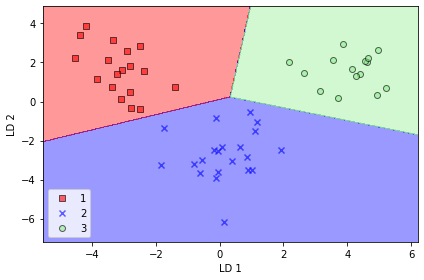

In [55]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_10.png', dpi=300)
plt.show()

<br>
<br>

# Using kernel principal component analysis for nonlinear mappings

## Implementing a kernel principal component analysis in Python

In [57]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, i]
                            for i in range(n_components)))

    return X_pc

<br>

### Example 1: Separating half-moon shapes

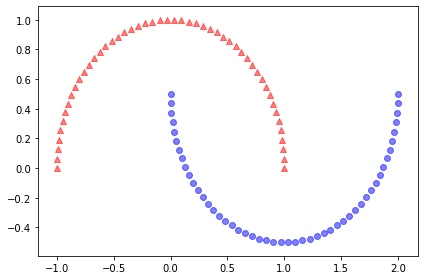

In [58]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()

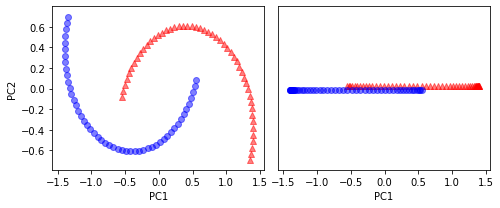

In [59]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


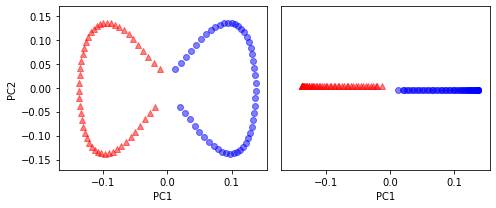

In [60]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show()

<br>

### Example 2: Separating concentric circles

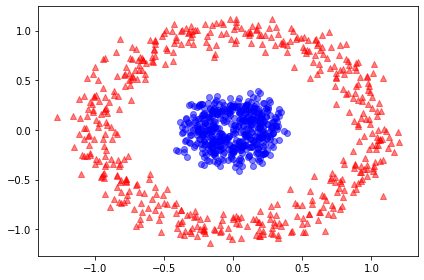

In [61]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

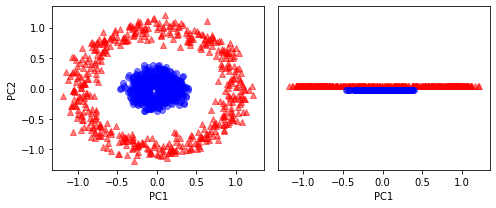

In [62]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


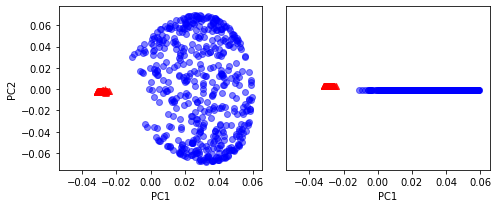

In [63]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

<br>
<br>

## Projecting new data points

In [64]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     alphas: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset 
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, i]
                              for i in range(n_components)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [74]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [75]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [76]:
x_proj = alphas[25] # original projection
x_proj

array([0.0788])

In [72]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

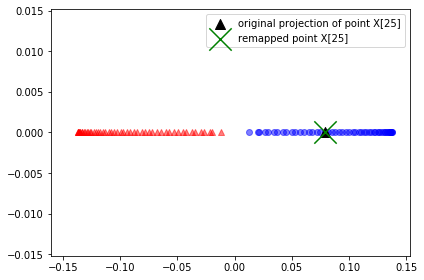

In [69]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('images/05_18.png', dpi=300)
plt.show()

<br>
<br>

## Kernel principal component analysis in scikit-learn

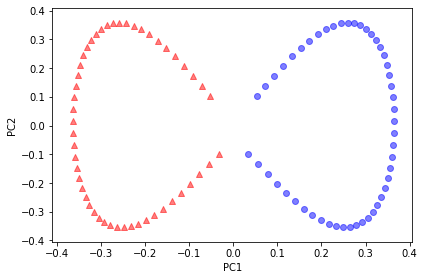

In [70]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()